In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math
from scipy import interpolate
plt.rc('font',family='Times New Roman',size=15)

In [22]:
Tref=773
lx=340
ly=150
endTime=0.1
timeStep=0.01
MCoke=12
MO2=32
pixelResolution=1e-6
YO2=0.22

## Temporal Evolution of Combustion Temperature,residual coke and reaction rate 

In [23]:
fieldminMaxFile="../postProcessing/minMaxComponents/0/fieldMinMax.dat"
with open(fieldminMaxFile,"r") as fp:
    comment=fp.readline()
    header=fp.readline()
header=header[1:-1].split()
indexs_processor=[]
for i,name in enumerate(header):
    if header[i]=="processor":
        indexs_processor.append(i)
indexs_processor.reverse()  

data=pd.read_csv(fieldminMaxFile,comment='#', sep='\t',header=None)
data=data.drop(indexs_processor,axis=1)
data.rename(columns=lambda x:header[x],inplace=True)
data.head()

,Time,field,min,location(min),max,location(max)
0,1.200000e-09,T,772.9158,(5.000000e-07 5.000000e-07 5.000000e-07),773.0,(1.855000e-04 6.950000e-05 5.000000e-07)
1,2.640000e-09,T,772.8225,(5.000000e-07 5.000000e-07 5.000000e-07),773.0,(4.750000e-05 1.350000e-05 5.000000e-07)
2,4.367999e-09,T,772.7211,(5.000000e-07 5.000000e-07 5.000000e-07),773.0,(4.750000e-05 1.350000e-05 5.000000e-07)
3,6.441599e-09,T,772.6131,(5.000000e-07 5.000000e-07 5.000000e-07),773.0,(4.750000e-05 1.350000e-05 5.000000e-07)
4,8.929917e-09,T,772.5011,(5.000000e-07 5.000000e-07 5.000000e-07),773.0,(1.135000e-04 3.450000e-05 5.000000e-07)


In [24]:
sampling_rate=10    
data_sampling=data[data.index%sampling_rate==0]
data_sampling.shape

(795, 6)

In [25]:
def readOpenFoamUField(file,nx,ny,normizedValue=1,component=0):
    with open(file,"r") as fp:
        lines=fp.readlines()
    for i,line in enumerate(lines):
        if line.startswith("internalField"):
            start=i+3
        elif line.startswith("boundaryField"):
            end=i-4
            break
    field=[]
    for i in np.arange(start,end+1):
        values=lines[i].replace('\n', '').split()
        values=[float(value.replace('(', '').replace(')', '')) for value in values]
        value=values[component]
        field.append(value/normizedValue)
    field=np.array(field).reshape(ny,nx)
    return field

In [26]:
def readOpenFoamField(file,nx,ny,normizedValue=1):
    with open(file,"r") as fp:
        lines=fp.readlines()
    for i,line in enumerate(lines):
        if line.startswith("internalField"):
            start=i+3
        elif line.startswith("boundaryField"):
            end=i-4
            break
    field=[]
    for i in np.arange(start,end+1):
        value=float(lines[i].replace('\n', ''))
        field.append(value/normizedValue)
    field=np.array(field).reshape(ny,nx)
    return field

In [27]:
times=np.arange(timeStep,endTime+timeStep,timeStep)
stimes=pd.Series([f"{t:.2f}".rstrip('.0') for t in times])
sampling_rate=1 
stimes=stimes[stimes.index%sampling_rate==0]
stimes.shape

(10,)

In [28]:

volumeAveragedCoke=[]
volumeAveragedReactionRate=[]
sumReactionRate=[]
inletfluxs=[]
for t in stimes:

    cokeField=readOpenFoamField(f"../{str(t)}/coke",lx,ly)
    volumeAveragedCoke.append(np.mean(cokeField))
    cokeReactionRateField=readOpenFoamField(f"../{str(t)}/cokeRectionRate",lx,ly)
    volumeAveragedReactionRate.append(np.mean(cokeReactionRateField))
    sumReactionRate.append(np.sum(cokeReactionRateField))

    densityField=readOpenFoamField(f"../{str(t)}/rho",lx,ly)
    UxField=readOpenFoamUField(f"../{str(t)}/U",lx,ly)
    inletFluxProfile=densityField[:,0]*UxField[:,0]
    inletfluxs.append(np.sum(inletFluxProfile))



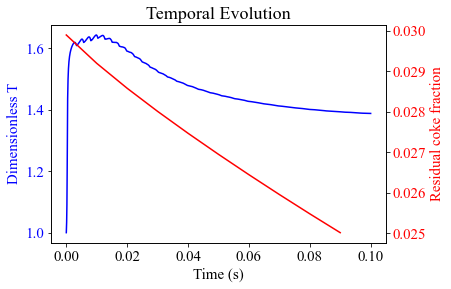

In [29]:
fig, ax = plt.subplots()
ax.set_xlabel(f"Time (s)")
ax.set_title(f"Temporal Evolution",color="k")

ax.plot(data["Time"],data["max"]/Tref,linestyle="-",label="Maximum Temperature",color="b")
ax.set_ylabel(f"Dimensionless T",color="b")
ax.tick_params(axis='y', labelcolor="b")

ax2 = ax.twinx()
ax2.plot(stimes.index*timeStep,volumeAveragedCoke,linestyle="-",color="r")
ax2.set_xlabel('Time (s)',color="r")
ax2.set_ylabel("Residual coke fraction",color="r")

ax2.tick_params(axis='y', labelcolor="r")

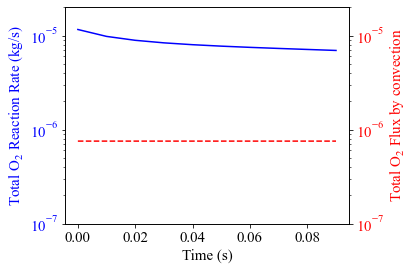

In [38]:
fig,ax=plt.subplots()
ax.plot(stimes.index*timeStep,np.array(sumReactionRate)*(pixelResolution*pixelResolution)*-1/MCoke*MO2,linestyle="-",color="b")
plt.rcParams.update({'mathtext.default':  'regular' })
ax.set_xlabel('Time (s)')
ax.set_ylabel("Total $O_2$ Reaction Rate (kg/s)",color="b")
ax.set_ylim([1e-7,2e-5])
ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor="b")

ax2 = ax.twinx()
ax2.plot(stimes.index*timeStep,np.array(inletfluxs)*pixelResolution*YO2,linestyle="--",color="r")
ax2.set_ylabel("Total $O_{2}$ Flux by convection",color="r")
ax2.set_ylim([1e-7,2e-5])
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor="r")

fig.tight_layout() 


## Transversely averaged O2 fraction and temperature distributions at three typical time instants

In [31]:
def show(timeInstant):
    cokeField=readOpenFoamField(f"../{str(timeInstant)}/coke",lx,ly)
    O2Field=readOpenFoamField(f"../{str(timeInstant)}/O2",lx,ly)
    TField=readOpenFoamField(f"../{str(timeInstant)}/T",lx,ly,Tref)

    fig,axs=plt.subplots(nrows=3, sharex=True, figsize=(13, 6))
    fig.tight_layout()
    plt.rcParams.update({'mathtext.default':  'regular' })
    # fig.suptitle(f"Field contours at time instant of {str(timeInstant)} s", fontsize=20)
    fig.text(0.55, 1.02, f'Field contours at time instant of {str(timeInstant)} s', transform=fig.transFigure, horizontalalignment='center', fontsize=18)
    im0=axs[0].imshow(cokeField,cmap="coolwarm")
    axs[0].set_title("coke fraction")
    bbox_ax0 = axs[0].get_position()
    loc_cbar0 = fig.add_axes([bbox_ax0.x1*1.01, bbox_ax0.y0, 0.02, bbox_ax0.y1-bbox_ax0.y0])
    cbar0 = fig.colorbar(im0, cax=loc_cbar0)

    im1=axs[1].imshow(O2Field,cmap="coolwarm")
    plt.rcParams.update({'mathtext.default':  'regular' })
    axs[1].set_title("${O_2}$ fraction")
    bbox_ax1 = axs[1].get_position()
    loc_cbar1 = fig.add_axes([bbox_ax1.x1*1.01, bbox_ax1.y0, 0.02, bbox_ax1.y1-bbox_ax1.y0])
    cbar1 = fig.colorbar(im1, cax=loc_cbar1)

    im2=axs[2].imshow(TField,cmap="coolwarm")
    axs[2].set_title("Temperature")
    bbox_ax2 = axs[2].get_position()
    loc_cbar2 = fig.add_axes([bbox_ax2.x1*1.01, bbox_ax2.y0, 0.02, bbox_ax2.y1-bbox_ax2.y0])
    cbar2 = fig.colorbar(im2, cax=loc_cbar2)

    

# show(t1)


In [39]:
t1=0.01
t2=0.05
t3=0.1

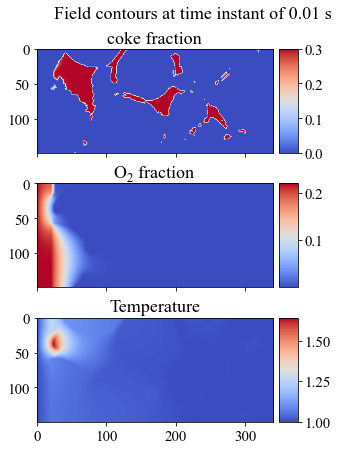

In [40]:
show(t1)

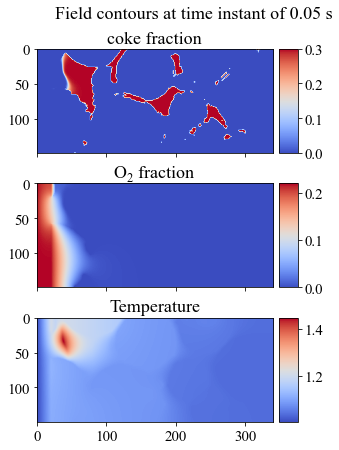

In [41]:
show(t2)

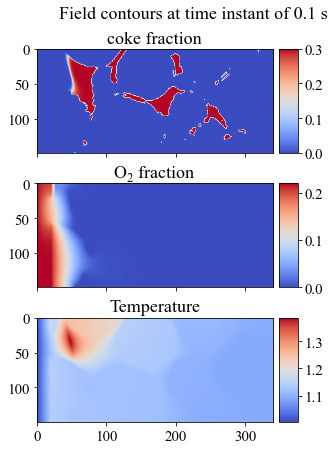

In [43]:
show(t3)

(0.0, 408.0)

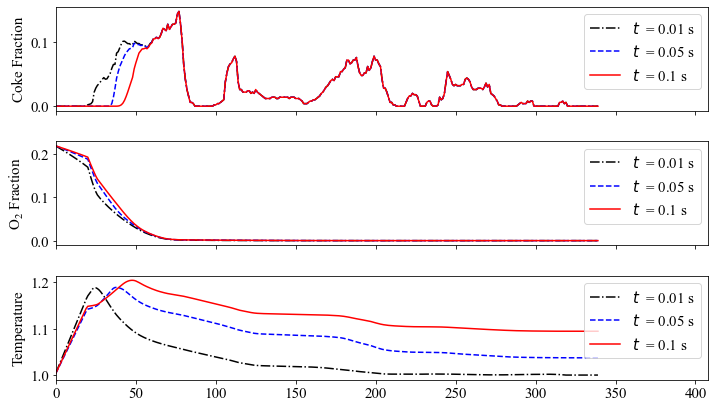

In [44]:

cokeField0=readOpenFoamField(f"../{str(t1)}/coke",lx,ly)
O2Field0=readOpenFoamField(f"../{str(t1)}/O2",lx,ly)
TField0=readOpenFoamField(f"../{str(t1)}/T",lx,ly,Tref)

cokeField1=readOpenFoamField(f"../{str(t2)}/coke",lx,ly)
O2Field1=readOpenFoamField(f"../{str(t2)}/O2",lx,ly)
TField1=readOpenFoamField(f"../{str(t2)}/T",lx,ly,Tref)


cokeField2=readOpenFoamField(f"../{str(t3)}/coke",lx,ly)
O2Field2=readOpenFoamField(f"../{str(t3)}/O2",lx,ly)
TField2=readOpenFoamField(f"../{str(t3)}/T",lx,ly,Tref)


fig,axs=plt.subplots(nrows=3, sharex=True, figsize=(10, 6))
fig.tight_layout()
axs[0].plot(np.mean(cokeField0,axis=0),linestyle="-.",color="k",label=fr"$\mathit{{t}}\ $ = {str(t1)} s")
axs[0].plot(np.mean(cokeField1,axis=0),linestyle="--",color="b",label=fr"$\mathit{{t}}\ $ = {str(t2)} s")
axs[0].plot(np.mean(cokeField2,axis=0),linestyle="-",color="r",label=fr"$\mathit{{t}}\ $ = {str(t3)} s")
axs[0].set_ylabel(f"Coke Fraction")
axs[0].legend()

axs[1].plot(np.mean(O2Field0,axis=0),linestyle="-.",color="k",label=fr"$\mathit{{t}}\ $ = {str(t1)} s")
axs[1].plot(np.mean(O2Field1,axis=0),linestyle="--",color="b",label=fr"$\mathit{{t}}\ $ = {str(t2)} s")
axs[1].plot(np.mean(O2Field2,axis=0),linestyle="-",color="r",label=fr"$\mathit{{t}}\ $ = {str(t3)} s")
axs[1].set_ylabel(f"$O_{2}$ Fraction")
axs[1].legend()

axs[2].plot(np.mean(TField0,axis=0),linestyle="-.",color="k",label=fr"$\mathit{{t}}\ $ = {str(t1)} s")
axs[2].plot(np.mean(TField1,axis=0),linestyle="--",color="b",label=fr"$\mathit{{t}}\ $ = {str(t2)} s")
axs[2].plot(np.mean(TField2,axis=0),linestyle="-",color="r",label=fr"$\mathit{{t}}\ $ = {str(t3)} s")
axs[2].set_ylabel(f"Temperature")
axs[2].legend()

axs[2].set_xlim([0,lx*1.2])    